In [3]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot 
import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from matplotlib import cm

In [4]:
gamma = 1.4     #Гамма, она же каппа
#Различные формулы из гаммы
g_m_1_over_2g = (gamma-1)/2/gamma      #g1
g_p_1_over_2g = (gamma+1)/2/gamma      #g2
g_m_1_over_2g_inv = 1/g_m_1_over_2g    #g3
g_m_1_over_2_inv = 2/(gamma-1)         #g4
g_p_1_over_2_inv = 2/(gamma+1)         #g5
g_m_1_over_g_p_1 = (gamma-1)/(gamma+1) #g6
g_m_1_over_2 = (gamma-1)/2             #g7
g_m_1 = gamma-1  

tol = 1e-8

In [5]:
ax_dict = {'x':1,'y':2}

In [6]:
def sound_speed(d,p):
    return (gamma*(p/d))**0.5

In [7]:
def sound_speed_w(W):
    d = W[0]
    p = W[-1]
    return sound_speed(d,p) 

In [8]:
def U_to_W(U):
    W = np.zeros_like(U)
    W[0] = U[0]
    W[1] = U[1]/U[0]
    W[2] = U[2]/U[0]
    W[3] = g_m_1*(U[3] - 0.5*(U[1]**2 + U[2]**2)/U[0])
    return W

In [9]:
def W_to_U(W):
    U = np.zeros_like(W)
    U[0] = W[0]
    U[1] = W[1]*W[0]
    U[2] = W[2]*W[0]
    U[3] = 0.5*(W[1]**2 + W[2]**2)*W[0]+W[3]/g_m_1
    return U


In [10]:
def flux(W,axis):
    F = np.zeros_like(W)
    E = 0.5*(W[1]**2 + W[2]**2)*W[0] + W[3]/g_m_1
    if axis == 'x':
        F[0] = W[1]*W[0]
        F[1] = W[1]**2 * W[0] + W[3]
        F[2] = W[1]*W[2]*W[0]
        F[3] = W[1]*(E + W[3])
    elif axis == 'y':
        F[0] = W[2]*W[0]
        F[1] = W[1]*W[2]*W[0]
        F[2] = W[2]**2 * W[0] + W[3]
        F[3] = W[2]*(E + W[3])       
    else:
        print ('wrong axis_fluxes')
        return -1
    return F

In [11]:
def q(p,p_star):
    if p_star > p:
        return (1 + g_p_1_over_2g*(p_star/p - 1))**0.5
    else :
        return 1

In [12]:
def enthalpy(W):
    return 0.5 * (W[1]**2 + W[2]**2) + gamma / g_m_1 * (W[-1]/W[0])

In [13]:
def limiter(e, dx,axis):
    """
    Computes the minmod approximation of the slope.
    
    Parameters
    ----------
    e : list or numpy.ndarray
        The input values as a 1D array of floats.
    dx : float
        The grid-cell width.
    
    Returns
    -------
    sigma : numpy.ndarray
        The minmod-approximated slope
        as a 2D array of floats.
    """
    sigma = np.zeros_like(e)
    for i in range(1, e.shape[0] - 1):
        for j in range(1, e.shape[1] - 1):
            if axis == 'x':
                de_minus = (e[i,j] - e[i - 1,j]) / dx
                de_plus = (e[i + 1,j] - e[i,j]) / dx
            if axis == 'y':
                de_minus = (e[i,j] - e[i,j-1]) / dx
                de_plus = (e[i,j+1] - e[i,j]) / dx
                    
            for k in range(4):
                
                if de_minus[k] * de_plus[k] > 0:
                    sigma[i,j,k] = 2 * de_minus[k] * de_plus[k] / (de_minus[k] + de_plus[k])
                else:
                    sigma[i,j,k] = 0.0
    return sigma

In [14]:
def get_speeds(W_l,W_r,p_star,axis):
    S_l = W_l[ax_dict[axis]] - sound_speed_w(W_l)*q(W_l[-1],p_star)
    S_r = W_r[ax_dict[axis]] + sound_speed_w(W_r)*q(W_r[-1],p_star)
    
    S_star = (W_r[-1] - W_l[-1] + \
          W_l[0]*W_l[ax_dict[axis]]*(S_l - W_l[ax_dict[axis]]) - \
          W_r[0]*W_r[ax_dict[axis]]*(S_r - W_r[ax_dict[axis]]))/( W_l[0]*(S_l - W_l[ax_dict[axis]]) - \
          W_r[0]*(S_r - W_r[ax_dict[axis]]) )
    
    return np.asarray((S_l,S_r,S_star))

In [15]:
def guess_p(W_l,W_r,axis):
    

    c_l = sound_speed(W_l[0],W_l[-1])
    c_r = sound_speed(W_r[0],W_r[-1])
    
    q_temp = 2.0
    
    d_l, u_l, p_l = W_l[0], W_l[ax_dict[axis]], W_l[-1]
    d_r, u_r, p_r = W_r[0], W_r[ax_dict[axis]], W_r[-1]
        
    p_pv = max(0.0, 0.5 * (p_l + p_r) - 0.125 * (u_r - u_l) * (d_l + d_r) * (c_l + c_r))
    p_min = min(p_l, p_r)
    p_max = max(p_l, p_r)
    q_max = p_max / p_min
          
    if q_max <= q_temp and p_min <= p_pv <= p_max:
        p_m = p_pv
    elif p_pv < p_min:
        p_m = ((c_l + c_r - 0.5 * g_m_1 * (u_r - u_l))/(c_l / p_l ** g_m_1_over_2g + c_r / p_r ** g_m_1_over_2g)) ** g_m_1_over_2g_inv
    else:
        g_l = ((g_p_1_over_2_inv / d_l) / (g_m_1_over_g_p_1 * p_l + p_pv)) ** 0.5
        g_r = ((g_p_1_over_2_inv / d_r) / (g_m_1_over_g_p_1 * p_r + p_pv)) ** 0.5
        p_m = (g_l * p_l  + g_r * p_r - (u_r - u_l)) / (g_l + g_r)
        
    return p_m

In [16]:
def F_HLLC(W,S_star,S,axis):
    D = np.asarray([0,0,0,S_star])
    D[ax_dict[axis]] = 1
    
    F_star = (S_star*(S*W_to_U(W) - flux(W,axis)) + \
              S*(W[-1] + W[0]*(S - W[ax_dict[axis]])*(S_star - W[ax_dict[axis]]))*D)/(S - S_star)
    return F_star

In [17]:
def hllc_flux(W_l, W_r, axis):
    p_star = guess_p(W_l,W_r, axis)
    S_l,S_r,S_star = get_speeds(W_l,W_r,p_star, axis)
    if 0 <= S_l:
        return flux(W_l,axis)
    if S_l <= 0 <= S_star:
        return F_HLLC(W_l,S_star,S_l,axis)
    if S_star <= 0 <= S_r:
        return F_HLLC(W_r,S_star,S_r,axis)
    if 0 >= S_r:
        return flux(W_r,axis)

In [18]:
def compute_flux_hllc_limiter(W,dx,axis):
    hllc_fluxes = np.zeros((N_points - 1,N_points - 1,4))
    speeds = np.zeros((N_points - 1,N_points - 1))
    grads = limiter(W,dx,axis)
    
    if axis == 'x':
        WL = (W + grads * dx / 2.0)[:-1,:,:]
        WR = (W - grads * dx / 2.0)[1:,:,:]
    if axis == 'y':
        WL = (W + grads * dx / 2.0)[:,:-1,:]
        WR = (W - grads * dx / 2.0)[:,1:,:]
        
    
    for i in range(N_points-1):
        for j in range(N_points-1):
            hllc_fluxes[i,j] = hllc_flux(WL[i,j],WR[i,j],axis)
            c_l = sound_speed(WL[i,j][0],WL[i,j][-1])
            c_r = sound_speed(WR[i,j][0],WR[i,j][-1])
            speeds[i,j] = max(WL[i,j][ax_dict[axis]] + c_l, WR[i,j][ax_dict[axis]] + c_r)

    return hllc_fluxes, np.max(speeds)

In [114]:
N_points = 31
x = np.linspace(0,1,N_points)
y = np.linspace(0,1,N_points)
decay_pos = 0.5
W_correct = np.zeros((N_points,N_points,4))
X, Y = np.meshgrid(x,y) #делаем двумерную сетку: в X х-координаты сетки, в Y y-координаты

In [115]:
#X

In [116]:
#Y

In [117]:
dx = 1./(N_points - 1)
dy = 1./(N_points - 1)
sigma = 0.9

W = np.zeros_like(W_correct)
U = np.zeros_like(W)

In [118]:
def init():
    W_u_l = np.array([0.5197, -0.6259, -0.3, 0.4])
    W_u_r = np.array([1.0, 0.1, -0.3, 1.0])
    W_d_l = np.array([0.8, 0.1, -0.3, 0.4])
    W_d_r = np.array([0.5313, 0.1, 0.4276, 0.4])
    t = 0.5
    return W_u_l, W_u_r, W_d_l, W_d_r, t

In [119]:
W_u_l, W_u_r, W_d_l, W_d_r, t = init()

In [120]:
W[(X<decay_pos)*(Y<decay_pos)] = W_d_l
W[(X<decay_pos)*(Y>=decay_pos)] = W_u_l
W[(X>=decay_pos)*(Y<decay_pos)] = W_d_r
W[(X>=decay_pos)*(Y>=decay_pos)] = W_u_r

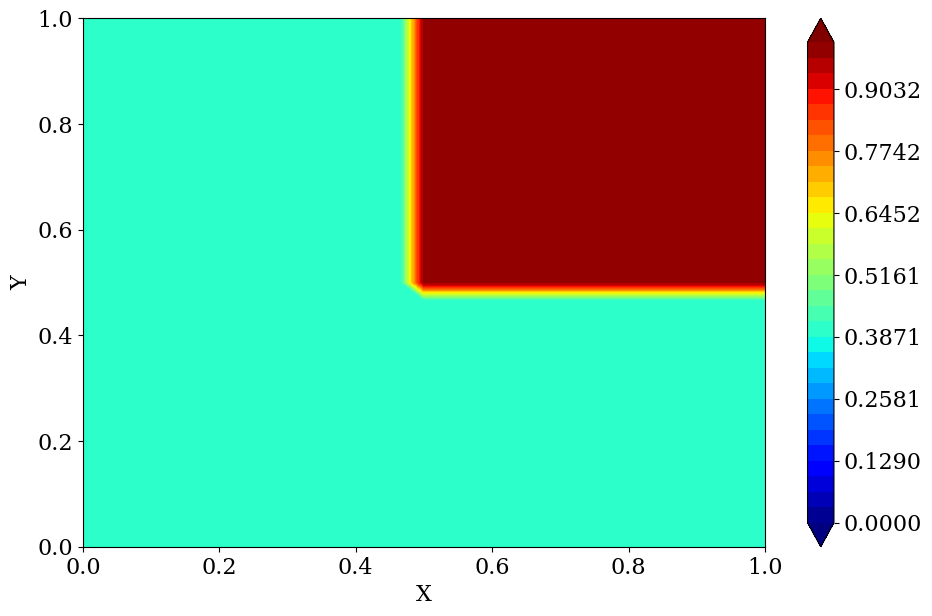

In [121]:
fig = pyplot.figure(figsize=(11,7), dpi=100)
#pyplot.contourf(X, Y, W[:,:,-1], alpha=0.5, extend='both', levels=np.linspace(0.16,1.71,32),cmap='jet')
pyplot.contourf(X, Y, W[:,:,-1], alpha=1., extend='both', levels=np.linspace(0.,1.,32),cmap='jet')
pyplot.colorbar()
#pyplot.quiver(X,Y, W[:,:,1], W[:,:,2])
pyplot.xlabel('X')
pyplot.ylabel('Y');

In [122]:
t_ = 0
t = 0.2
U_n = np.copy(U)
U_n_star = np.copy(U)
while t_<t:
    U = W_to_U(W.T).T
    
    hllc_fluxes_f,m_speed_f = compute_flux_hllc_limiter(W,dx,'x')
    hllc_fluxes_g,m_speed_g = compute_flux_hllc_limiter(W,dx,'y')
    
    M_speed = max(m_speed_f,m_speed_g)
    
    dt = sigma*min(dx,dy)/np.max(M_speed)/2.
    
    U_n_star[1:-1,1:-1,:] = U[1:-1,1:-1,:] + dt/dx*(hllc_fluxes_f[:-1,1:,:] - hllc_fluxes_f[1:,1:,:]) + \
                       dt/dy*(hllc_fluxes_g[1:,:-1,:] - hllc_fluxes_g[1:,1:,:])
    U_n_star[0,:,:] = U_n_star[1,:,:]
    U_n_star[-1,:,:] = U_n_star[-2,:,:]
    
    U_n_star[:,0,:] = U_n_star[:,1,:]
    U_n_star[:,-1,:] = U_n_star[:,-2,:]    
    
    W_star = U_to_W(U_n_star.T).T
    
    hllc_fluxes_f,m_speed_f = compute_flux_hllc_limiter(W_star,dx,'x')
    hllc_fluxes_g,m_speed_g = compute_flux_hllc_limiter(W_star,dx,'y')
    
    U_n[1:-1,1:-1,:] = 0.5 * U[1:-1,1:-1,:] + 0.5 * (U_n_star[1:-1,1:-1,:] + 
                       dt/dx*(hllc_fluxes_f[:-1,1:,:] - hllc_fluxes_f[1:,1:,:]) + \
                       dt/dy*(hllc_fluxes_g[1:,:-1,:] - hllc_fluxes_g[1:,1:,:]))
    print('t=',t_)
    U_n[0,:,:] = U_n[1,:,:]
    U_n[-1,:,:] = U_n[-2,:,:]
    
    U_n[:,0,:] = U_n[:,1,:]
    U_n[:,-1,:] = U_n[:,-2,:]
    
    W = U_to_W(U_n.T).T
    
    #fig = pyplot.figure(figsize=(11,7), dpi=100)
    #pyplot.contourf(X, Y, W[:,:,-1], alpha=0.5, extend='both', levels=np.linspace(0,1))
    #pyplot.colorbar()
    #pyplot.quiver(X,Y, W[:,:,1], W[:,:,2])
    #pyplot.xlabel('X')
    #pyplot.ylabel('Y')
    #pyplot.show()

    t_ = t_+dt

t= 0
t= 0.010314566748134323
t= 0.020608375485892654
t= 0.03083814114299702
t= 0.04097727062156172
t= 0.051030274680633834
t= 0.061026565455583805
t= 0.07100832528007382
t= 0.08101977726886911
t= 0.09096362696087566
t= 0.1008543792536669
t= 0.11071359256442498
t= 0.12055774324180324
t= 0.13040081167143563
t= 0.1402498040492586
t= 0.15007644934815811
t= 0.15988918282102704
t= 0.16969505917803043
t= 0.17949879520801806
t= 0.18930383605002465
t= 0.19911313007802378


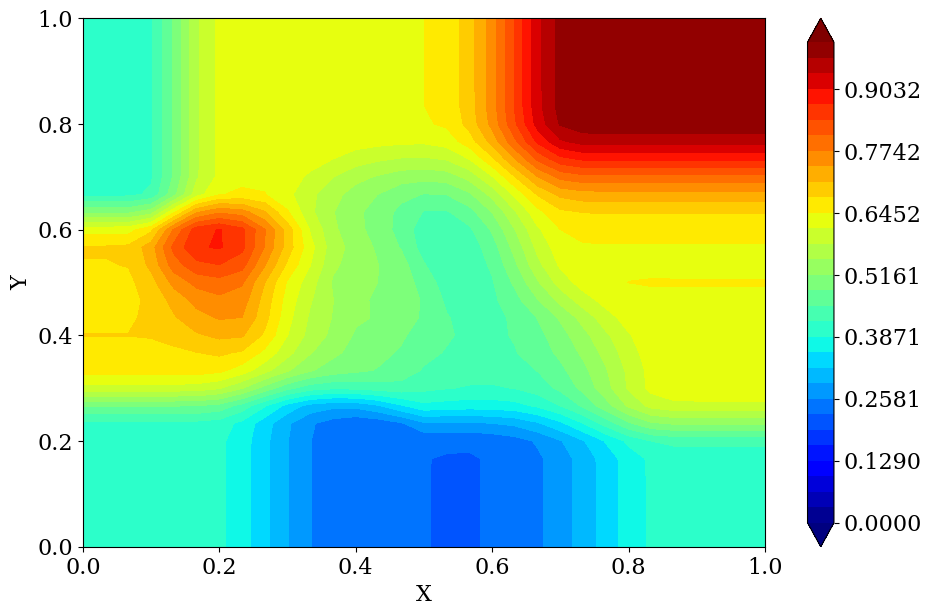

In [123]:
fig = pyplot.figure(figsize=(11,7), dpi=100)
pyplot.contourf(X, Y, W[:,:,-1], alpha=1., extend='both', levels=np.linspace(0.,1.,32),cmap='jet')
pyplot.colorbar()
#pyplot.quiver(X,Y, W[:,:,1], W[:,:,2])
pyplot.xlabel('X')
pyplot.ylabel('Y');
#pyplot.savefig('2d_hllc_2nd_order_101_02s.png', bbox_inchces = 'tight')